# Part 4: Exploratory Data Analysis

This is an exploratory data analysis of "Data Scientist" jobs details that were scraped from www.glassdoor.co.uk. The data were enriched, cleaned and reduced in **Part 2**, and features were extracted from a text analysis of job titles and role descriptions in **Part 3**, that will make exploratory and further analysis easier. Here in **Part 4**, I will do some exploratory data analysis to learn more about Data Scientist roles advertised in the UK.

## Setup

### Import Packages & Modules

In [58]:
# import packages and modules
import itertools
import json
import pandas as pd
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import plotly.express as px
import plotly.io as pio

### Display Settings

In [59]:
# ensure all columns and rows will be displayed if/when you print the dataframe
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

# ensure all figures will have a white background in this notebook
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

# plotly setting for notebooks
pio.renderers.default = "notebook"

### Import Data & Dictionaries

In [60]:
# provide the path to the location of the cleaned scraped glassdoor job data
path = './data/'

# provide glassdoor scrape date
scrapedate = '14Dec2020'  # e.g. '14Dec2020', '16Feb2021'

# create the absolute path to the wrangled data scientist job data
filename = os.path.join(path, f"dsjobs_df_{scrapedate}_wrangled.pkl")

# read the cleaned data scientist jobs data (.pkl file) into a dataframe
dsjobs = pd.read_pickle(filename)

# display dataframe info to check that it's what you expected
dsjobs.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Columns: 155 entries, job_title to degree_any
dtypes: Int64(1), bool(130), category(7), float64(8), object(9)
memory usage: 141.8+ KB


In [61]:
# import the necessary dictionaries produced in Part 3
with open('dsjobs_dicts.pkl', 'rb') as f:
    dsjobs_dicts = pickle.load(f)

# put the dictionaries in a list
dsjobs_dicts_ls = list(dsjobs_dicts.keys())
dsjobs_dicts_ls


['dict_skills', 'dict_tools', 'dict_degsubjects', 'dict_qualifications']

These dictionaries will make the analysis and plotting of the skills, tools, qualifications and degree subjects mentioned in the job descriptions easier.

In [62]:
# print one of the dictionaries as an example to see the structure
print(json.dumps(dsjobs_dicts['dict_qualifications'], indent=4))


{
    "bachelors": {
        "re": "\\bbachelor\\'?|\\bhonours\\b|\\bbsc\\b|\\bbs\\b|\\bba\\b",
        "label": "Bachelor's"
    },
    "masters": {
        "re": "\\bmaster\\'?s\\b|\\bmsc\\b|\\bma\\b",
        "label": "Master's"
    },
    "phd": {
        "re": "\\bphd\\b|\\bdphil\\b|\\bdoctorate\\b",
        "label": "PhD"
    },
    "degree_any": {
        "label": "Any Degree"
    }
}


# Exploratory data analysis

In [63]:
# colour palette
pink = '#FFA6D9'  # rgba: 255, 166, 217, 1
purple = '#9161F2'  # rgba - 145, 97, 242, 1
green = '#6BFFB3'  # rgba - 107, 255, 179, 1
grey = '#999999'

## About the hiring companies

### Age:

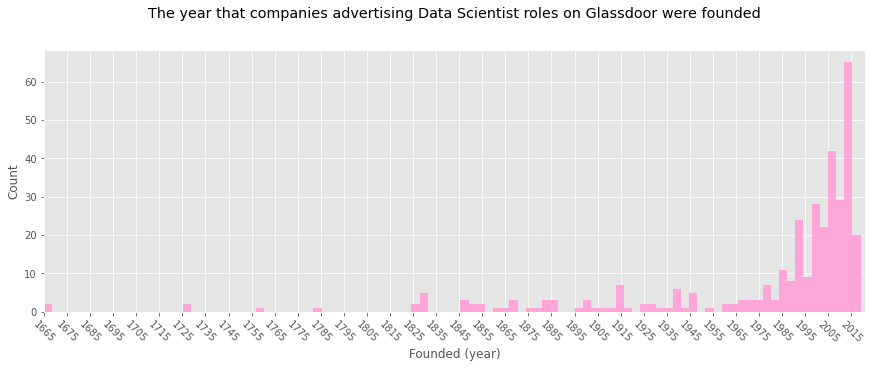

In [64]:
plt.style.use('ggplot')
plt.figure(constrained_layout=True, figsize=(12, 5))
dsjobs['founded'].plot(kind='hist', bins=100, color=pink)
plt.xlim(left=np.min(dsjobs['founded']), right=2021)
plt.xticks(np.arange(np.min(dsjobs['founded']), np.max(dsjobs['founded']), step=10), rotation=-45)
plt.xlabel('Founded (year)')
plt.ylabel('Count')
plt.title("The year that companies advertising Data Scientist roles on Glassdoor were founded", y=1.1)
plt.savefig("./images/pt4_figures/founded.jpg", dpi=300, bbox_inches = 'tight')
plt.show()

Most of the companies advertising data scientist jobs were founded in the last 30-40 years. 

### Size:

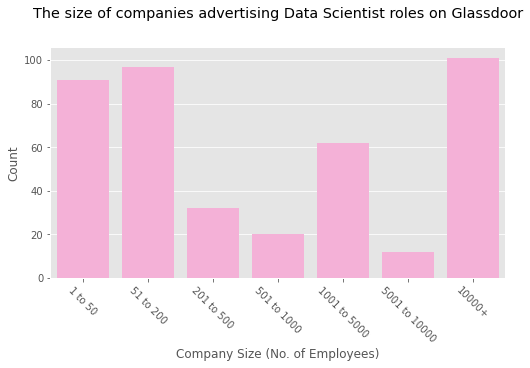

In [65]:
fig = plt.figure(constrained_layout=True, figsize=(7, 5))
spec = gridspec.GridSpec(ncols=15, nrows=1, figure=fig)
sns.countplot(  
        x='size', 
        data=dsjobs,
        color=pink,
)
plt.style.use('ggplot')

plt.xticks(rotation=-45)
plt.xlabel("Company Size (No. of Employees)")
plt.ylabel("Count")
plt.title("The size of companies advertising Data Scientist roles on Glassdoor", y=1.1)
plt.savefig("./images/pt4_figures/size.jpg", dpi=300, bbox_inches = 'tight')
plt.show()



It looks like most of the advertised data scientist roles in the UK tend to be in small or very large companies.

### Sector:

Which sectors are most data scientist jobs in?

In [66]:
# count of the sectors that the data science jobs are in: group dsjobs by sector,
# drop jobs without a sector, use the job_title column to get the counts per sector
sectors_cnt_all = dsjobs.groupby(by='sector', dropna=True).count()['job_title']

# the proportion of jobs in each sector: divide count by the no. of jobs in each sector
sectors_pct = sectors_cnt_all/sum(sectors_cnt_all)*100

# for plotting the proportion of jobs in each sector in a clean way:
# group sectors with a representation of <2% of jobs into an 'Other' category
sectors_other = sectors_cnt_all[(sectors_pct)<2]

# remove 'Other' sectors from the sectors list
sectors_cnt = sectors_cnt_all.drop(sectors_other.index, axis=0)

# sort the sectors_cnt in descending order for plotting
sectors_cnt = sectors_cnt.sort_values(ascending=False)


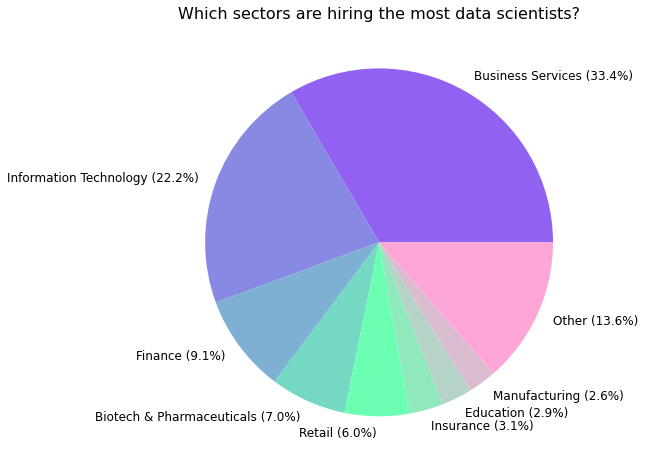

'Other' sectors (% jobs):
sector
Accounting & Legal                    1.8
Aerospace & Defense                   1.6
Arts, Entertainment & Recreation      1.3
Construction, Repair & Maintenance    0.3
Government                            1.0
Health Care                           1.8
Media                                 1.8
Non-Profit                            0.3
Oil, Gas, Energy & Utilities          1.3
Telecommunications                    1.0
Transportation & Logistics            0.5
Travel & Tourism                      0.8
Name: job_title, dtype: float64)


In [67]:
# plot the proportion of data science jobs in each sector as a pie chart
plt.style.use('ggplot')
plt.subplots(figsize=(14,8))
labels = list(sectors_cnt.index)
sizes = list(sectors_cnt.values)
labels.append('Other')
sizes.append(sectors_other.sum())
pcts = list(map(lambda x: np.round(x/np.sum(sizes)*100, 1), sizes))

# create colour map
cmap = np.ones((9, 4))
cmap[:4, 0] = np.linspace(start=145/255, stop=107/255, num=5)[:-1]
cmap[:4, 1] = np.linspace(start=97/255, stop=255/255,  num=5)[:-1]
cmap[:4, 2] = np.linspace(start=242/255, stop=179/255, num=5)[:-1]

cmap[4, :] = np.array([107/255, 255/255, 179/255, 1])

cmap[5:, 0] = np.linspace(start=107/255, stop=255/255, num=5)[1:]
cmap[5:, 1] = np.linspace(start=255/255, stop=166/255, num=5)[1:]
cmap[5:, 2] = np.linspace(start=179/255, stop=217/255, num=5)[1:]
# print(cmap)

plt.pie(sizes, 
        labels=list(map(lambda x, y: x+' ('+str(y)+'%)', labels, pcts)),
        startangle=0,
        textprops={'fontsize': 12},
        pctdistance=0.85,
        colors=cmap,
)
plt.title("Which sectors are hiring the most data scientists?", fontsize=16)
plt.savefig("./images/pt4_figures/sector.jpg", dpi=300, bbox_inches = 'tight')
plt.show()

# print names and %s of 'Other' sectors
sectors_other_pct = round(sectors_other[sectors_other>0]/sum(sectors_cnt_all)*100,1)
print(f"'Other' sectors (% jobs):\n{sectors_other_pct})")



### Industry:

In [68]:
# count of the industries that the data science jobs are in: group dsjobs by industry,
# drop jobs without a industry, use the job_title column to get the counts per industry
industries_cnt_all = dsjobs.groupby(by='industry', dropna=True).count()['job_title']

# the proportion of jobs in each industrie: divide count by the no. of jobs in each industry
industries_pct = industries_cnt_all/sum(industries_cnt_all)*100

# for plotting the proportion of jobs in each industrie in a clean way:
# group industries with a representation of <2% of jobs into an 'Other' category
industries_other = industries_cnt_all[(industries_pct)<2]

# remove 'Other' industries from the industries list
industries_cnt = industries_cnt_all.drop(industries_other.index, axis=0)

# sort the industries_cnt in descending order for plotting
industries_cnt = industries_cnt.sort_values(ascending=False)

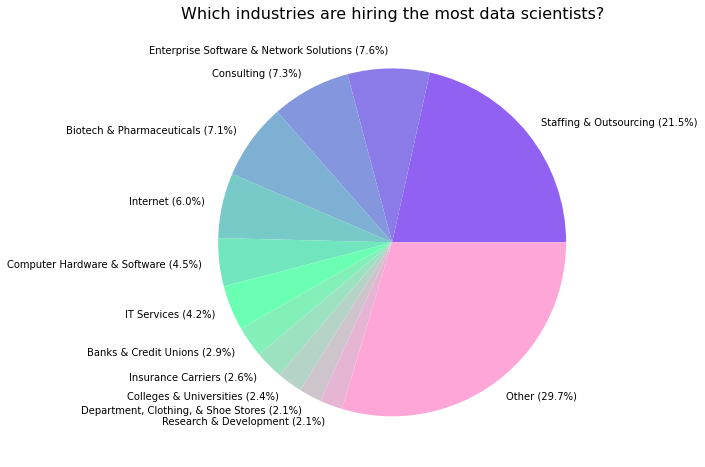

Staffing & Outsourcing, Enterprise Software & Network Solutions, Consulting, Biotech & Pharmaceuticals are the industries advertising the most data science roles

'Other' industries (% jobs):
industry
Accounting                                   1.8
Health Care Services & Hospitals             1.8
Investment Banking & Asset Management        1.8
Financial Transaction Processing             1.8
Lending                                      1.6
Aerospace & Defense                          1.6
Architectural & Engineering Services         1.3
Advertising & Marketing                      1.3
Food & Beverage Stores                       1.3
Consumer Products Manufacturing              1.0
Federal Agencies                             1.0
Financial Analytics & Research               0.8
Energy                                       0.8
Drug & Health Stores                         0.8
Publishing                                   0.8
Talent & Modeling Agencies                   0.8
Telecommunicati

In [69]:
# plot the proportion of data science jobs in each industry as a pie chart
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(11,8))
labels = list(industries_cnt.index)
sizes = list(industries_cnt.values)
labels.append('Other')
sizes.append(industries_other.sum())
pcts = list(map(lambda x: np.round(x/np.sum(sizes)*100, 1), sizes))

# create colour map
cmap = np.ones((13, 4))
cmap[:6, 0] = np.linspace(start=145/255, stop=107/255, num=7)[:-1]
cmap[:6, 1] = np.linspace(start=97/255, stop=255/255,  num=7)[:-1]
cmap[:6, 2] = np.linspace(start=242/255, stop=179/255, num=7)[:-1]

cmap[6, :] = np.array([107/255, 255/255, 179/255, 1])

cmap[7:, 0] = np.linspace(start=107/255, stop=255/255, num=7)[1:]
cmap[7:, 1] = np.linspace(start=255/255, stop=166/255, num=7)[1:]
cmap[7:, 2] = np.linspace(start=179/255, stop=217/255, num=7)[1:]
# print(cmap)

plt.pie(sizes, 
        labels=list(map(lambda x, y: x+' ('+str(y)+'%)', labels, pcts)),
        startangle=0,
        textprops={'fontsize': 10},
        pctdistance=0.92,
        colors=cmap,
)
plt.title("Which industries are hiring the most data scientists?", fontsize=16)
plt.savefig("./images/pt4_figures/industry.jpg", dpi=300, bbox_inches = 'tight')
plt.show()

# print most common industries
print(f"{', '.join(labels[:4])} are the industries advertising the most data science roles\n")

# print names and %s of 'Other' industries
industries_other_pct = round(industries_other[industries_other>0]/sum(industries_cnt_all)*100,1)
print(f"'Other' industries (% jobs):\n{industries_other_pct.sort_values(ascending=False)})")



### Employee ratings: 

Glassdoor company ratings, which are based on employee feedback, are helpful indicators for job seekers. I will plot boxplots for all the ratings to see their distributions. This will help me to identify companies that are rated exceptionally well or unfavourably (above or below the quartiles) with respect to the aspects most important to me.

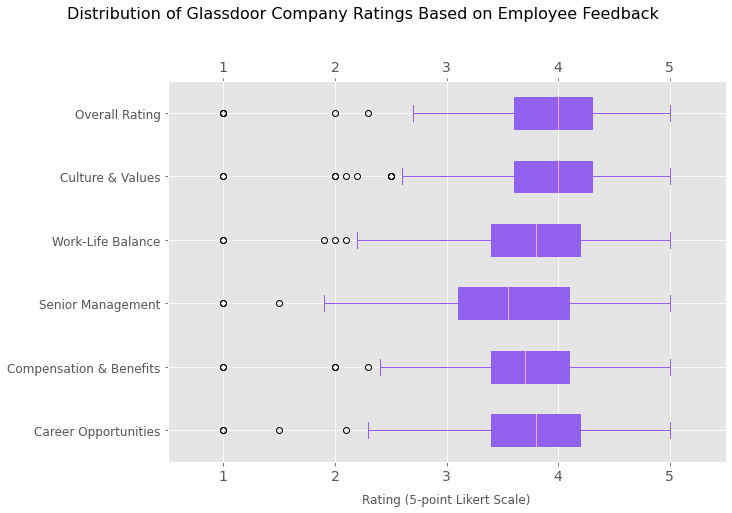

In [70]:
# # if diversity rating is available (not in 2022 scrapes) uncomment below:
# ratings_ls = ['rating', 'rating_culturevalues', 'rating_worklifebalance', 'rating_diversity', 'rating_seniormgmt', 'rating_compbenefits', 'rating_careerops']
# labels=["Career Opportunities", "Compensation & Benefits", "Senior Management", "Diversity", "Work-Life Balance", "Culture & Values", "Overall Rating"]

# if diversity rating is unavailable (not in 2022 scrapes) uncomment below:
ratings_ls = ['rating', 'rating_culturevalues', 'rating_worklifebalance', 'rating_seniormgmt', 'rating_compbenefits', 'rating_careerops']
labels=["Career Opportunities", "Compensation & Benefits", "Senior Management", "Work-Life Balance", "Culture & Values", "Overall Rating"]

ratings_ls.reverse()
ratings = dsjobs[ratings_ls]

# plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10,7))
fig = ratings.boxplot(vert=False, showfliers=True, labels=labels, patch_artist=True, color=purple, medianprops={'color': pink, 'lw': 1})
ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)
plt.xlim(0.5,5.5)
plt.xticks(fontsize=14)
plt.xlabel("Rating (5-point Likert Scale)", fontsize=12, labelpad=10)
plt.yticks(ticks=[1,2,3,4,5,6],labels=labels, fontsize=12)
plt.title("Distribution of Glassdoor Company Ratings Based on Employee Feedback", y=1.15, fontsize=16, x=0.35)
plt.savefig("./images/pt4_figures/ratings.jpg", dpi=300, bbox_inches = 'tight')
plt.show()

The blue lines in the middle of the boxes represent the medians, the limits of the boxes are the 25th and 75th percentiles (Q1 and Q3), the distance between them is the interquartile range [IQR], the ends of whiskers are the "minimum" (Q1-1.5 x IQR) and "maximum" (Q3+1.5 x IQR), and the circles represent outliers

These results indicate that overall, and across most areas, a rating of 4 or above is considered a high rating, except for "Senior Management", which varies the most; a rating of 3.5 for "Senior Management" can be considered better than average.

## Location: where in the UK are data scientist roles based?

The employers advertising jobs on glassdoor.co.uk list the job location as they wish, which means how specific or detailed they are varies. To standaridize the locations, I parsed the location given by employers and used it with the Ordinance Survey API to get all elements of the location. Having the full location details will allow me to look at how jobs are spread across the countries and regions of the UK, and visualise this on a map.

### Inter-country variations

In [71]:
# look at the counts of jobs in each UK country
print(dsjobs['api_country'].value_counts(),'\n')


England             451
Scotland             21
Northern Ireland     11
Wales                 8
Name: api_country, dtype: int64 



Most UK data scientist roles advertise on glassdoor.co.uk are based in England

### Regional variations

For data scientists wanting to live more in a more rural area, knowing which regions advertise the most data scientist jobs would be very useful; if you live in a region with a high number of advertised roles, you can be more confident that you'll always be in commuting distance of your job, without having to live in a city.

In [72]:
# look at the counts of jobs in each UK region
print(dsjobs['api_region'].value_counts(),'\n')

London                      293
South East                   36
East of England              35
North West                   28
South West                   22
Scotland                     21
Northern Ireland             11
West Midlands                11
Yorkshire and the Humber     11
East Midlands                10
Wales                         8
North East                    2
Name: api_region, dtype: int64 



As I expected, most UK data scientist roles advertised on glassdoor.co.uk are based in London, but to better appreciate how they compare and vary in other parts of the UK, I will plot the regional counts on a map of the UK. To do this I will need to manipulate the data and use a **GeoJSON** file of UK region boundaries. 

GeoJSON is a  JavaScript Object Notation (JSON) based format designed to represent geographical features with their non-spatial attributes. The file is a collection of information about the geographical features, their spatial extents, and properties. An object in this file may indicate a geometry (Point, LineString, Polygon), a feature or collection of features:

- addresses and places are represented as points
- streets, main roads and borders as line strings, and 
- **countries, provinces, and land regions as polygons**

The NUTS classification (Nomenclature of territorial units for statistics) is a hierarchical geocode standard for referencing the subdivisions of countries for statistical purposes:

- NUTS 1: major socio-economic regions
- NUTS 2: basic regions for the application of regional policies
- NUTS 3: small regions for specific diagnoses

The regions I am interested in are the NUTS Levels 1 regions: London, South East, South West, East of England, East Midlands, West Midlands, North East, North West, Yorkshire and the Humber, Scotland, Wales, and Northern Ireland.   

The GeoJSON I will be using was published by the Office for National Statistics (ONS) on the [UK government's website](https://www.data.gov.uk/dataset/2aa6727d-c5f0-462a-a367-904c750bbb34/nuts-level-1-january-2018-full-clipped-boundaries-in-the-united-kingdom). In this GeoJSON, the polygon for each region has a property that is the region's name, e.g. "North East (England)"; I will use this to join my job count by region data to the regions polygons in the GeoJSON.

In [73]:
# create a dataframe of the job counts by region data in dsjobs
ds_regioncounts = pd.DataFrame(dsjobs['api_region'].value_counts())
ds_regioncounts.rename(columns={'api_region': 'count'}, inplace=True)
print(ds_regioncounts)


                          count
London                      293
South East                   36
East of England              35
North West                   28
South West                   22
Scotland                     21
Northern Ireland             11
West Midlands                11
Yorkshire and the Humber     11
East Midlands                10
Wales                         8
North East                    2


In [74]:
# create a list of region codes in the same order as the index of ds_regioncounts; 
# the codes will be added to ds_regioncounts and be used to join the job count by 
# region data to the region polygons in the GeoJSON
region_codes = ['L', 'SE', 'EE', 'NW', 'SW','SC',
                'Y', 'WM', 'NI', 'EM', 'WA', 'NE']

# create a dictionary that links the region codes to the region names in the dsjobs data set
ds_regions_codes_dict = dict(zip(list(ds_regioncounts.index), region_codes))

# use the dictionary to link the region codes to the region job count dataframe
ds_regioncounts['region_codes'] = ds_regioncounts.index.map(ds_regions_codes_dict)
ds_regioncounts

count region_codes
London                      293            L
South East                   36           SE
East of England              35           EE
North West                   28           NW
South West                   22           SW
Scotland                     21           SC
Northern Ireland             11            Y
West Midlands                11           WM
Yorkshire and the Humber     11           NI
East Midlands                10           EM
Wales                         8           WA
North East                    2           NE

In [76]:
# open and load GeoJSON file in eda_proj folder as dict
with open('./misc/NUTS_Level_1_(January_2018)_Boundaries_super.geojson') as f:
    # returns JSON object as a dictionary
    json_regions = json.load(f)

# extract the region names from each polygon in the GeoJSON into a list
json_regions_ls = []
for i in json_regions['features']:
    json_regions_ls.append(i['properties']['nuts118nm'])

print('\n'.join(json_regions_ls))



North East (England)
North West (England)
Yorkshire and The Humber
East Midlands (England)
West Midlands (England)
East of England
London
South East (England)
South West (England)
Wales
Scotland
Northern Ireland


In [77]:
# create a list of region codes in the same order as json_regions_ls; 
region_codes_2 = ['NE', 'NW', 'Y','EM','WM','EE','L','SE','SW','WA','SC','NI']

# create a dictionary that links the region codes to the region names in the GeoJSON
json_regions_codes_dict = dict(zip(region_codes_2, json_regions_ls))

# use the dictionary to link the GeoJSON region names to the region job count data 
# in ds_regioncounts
ds_regioncounts['json_region'] = ds_regioncounts['region_codes'].map(json_regions_codes_dict)
print(ds_regioncounts)


                          count region_codes               json_region
London                      293            L                    London
South East                   36           SE      South East (England)
East of England              35           EE           East of England
North West                   28           NW      North West (England)
South West                   22           SW      South West (England)
Scotland                     21           SC                  Scotland
Northern Ireland             11            Y  Yorkshire and The Humber
West Midlands                11           WM   West Midlands (England)
Yorkshire and the Humber     11           NI          Northern Ireland
East Midlands                10           EM   East Midlands (England)
Wales                         8           WA                     Wales
North East                    2           NE      North East (England)


In [78]:
fig = px.choropleth_mapbox(ds_regioncounts, 
                        geojson=json_regions, 
                        color=ds_regioncounts['count'],
                        color_continuous_scale="purp",
                        locations=ds_regioncounts['json_region'], 
                        featureidkey='properties.nuts118nm',
                        mapbox_style="carto-positron", 
                        center={"lat": 55.3781, 
                                "lon": -4.5},
                        zoom=4,
                        width=500,
                        height=600,
                        title='UK Data Scientist Job Openings by Region'
                        )

fig.update_geos(fitbounds='locations', visible=False)
fig.update_layout(margin={'r': 60, 't': 60, 'l': 60, 'b': 60})
fig.write_html("C:/Users/hinal/Documents/Work/eda_proj/figures/jobsbyregion.html")
fig.show()


In [79]:
fig = px.colors.sequential.swatches_continuous()
fig.show()

Seeing the regional job counts plotted, and being able to hover over the regions to see the count values, makes it easy to appreciate the start difference in the number of data scientist positions between London and the rest of the country. The plot also makes it easy to spot that if a data sicentist did want to move to the North of England, the best region for jobs is the North West.

### Top cities for data scientist roles

For data scientists wanting to live in a UK city, London is the obvious choice, since the vast majority of data science roles are advertised by companies based in London/Greater London. However, for data scientists wanting to settle in a city outside of London, it's less obvious where those jobs would be. I'll take a look for the top 10 cities outside of London for advertised data scientist roles.

In [80]:
# look at the counts of jobs in each UK country
print(dsjobs['api_citytownvilham'].value_counts(ascending=False)[1:11],'\n')

Cambridge      22
Manchester     15
Edinburgh      12
Belfast        11
Reading         8
Bristol         6
Cheltenham      5
Glasgow         5
Southampton     5
Cardiff         4
Name: api_citytownvilham, dtype: int64 



Outside of London, Cambridge is the city with the most advertised data scientist roles. In Northern England, Manchester is hiring the most data scientists. The capitals of the devolved nations are unsurprisingly also in this top 10 cities for data scientist roles. Other cities hiring data scientists are Reading, Bristol, Cheltenham, Glasgow and Southampton.

## About the desired candidates

### Education: what educational background are employers looking for?

To understand what educational background employers are looking for in their data scientists, in Part 2, I searched the job description text for mentions of qualifications and mentions of particular subjects alongside them. The results were recorded as boolean columns for each qualification/subject. The column headers for the boolean columns, the string labels for each qualification/subject, were stored in dictonaries and pickled, and have been loaded here. I will use these dictionaries to analyse the results recorded in `dsjobs`. 

In [81]:
# print dict_qualifications to see the structure
print(json.dumps(dsjobs_dicts['dict_qualifications'], indent=4))

{
    "bachelors": {
        "re": "\\bbachelor\\'?|\\bhonours\\b|\\bbsc\\b|\\bbs\\b|\\bba\\b",
        "label": "Bachelor's"
    },
    "masters": {
        "re": "\\bmaster\\'?s\\b|\\bmsc\\b|\\bma\\b",
        "label": "Master's"
    },
    "phd": {
        "re": "\\bphd\\b|\\bdphil\\b|\\bdoctorate\\b",
        "label": "PhD"
    },
    "degree_any": {
        "label": "Any Degree"
    }
}


In [82]:
# print dict_qualifications_results to see the structure
print(json.dumps(dsjobs_dicts['dict_degsubjects'], indent=4))

{
    "degree_statistics": {
        "re": "\\bstatistics\\b",
        "label": "Statistics"
    },
    "degree_compsci": {
        "re": "\\bcomputer science\\b",
        "label": "Computer Science"
    },
    "degree_software_engineering": {
        "re": "\\bsoftware engineering\\b",
        "label": "Software Engineering"
    },
    "degree_economics": {
        "re": "\\beconomics\\b",
        "label": "Economics"
    },
    "degree_maths": {
        "re": "\\bmaths\\b|\\bmathematics\\b",
        "label": "Maths"
    },
    "degree_physics": {
        "re": "\\bphysics\\b",
        "label": "Physics"
    },
    "degree_engineering": {
        "re": "\\bengineering\\b",
        "label": "Engineering"
    },
    "degree_biology": {
        "re": "\\bbiolog\\b|\\bbioinformatics\\b",
        "label": "Biology"
    },
    "degree_chemistry": {
        "re": "\\bchemistry\\b",
        "label": "Chemistry"
    },
    "degree_datasci": {
        "re": "\\bdata science\\b",
        "label"

In [83]:
# calculate % jobs mentioning a degree qualifications/subjects

# initialise a dictionary to store results
dict_qualifications_results = {}

# identify qualifications mentioned in >1% jobs
for key, val in dsjobs_dicts['dict_qualifications'].items():
    pct = dsjobs[key].mean()*100
    if pct >= 1:
        label = val['label']
        dict_qualifications_results[label] = pct.round(1)

# initialise a dictionary to store results
dict_degsubjects_results = {}

for key, val in dsjobs_dicts['dict_degsubjects'].items():
    pct = dsjobs[key].mean()*100
    if pct >= 1:
        label = val['label']
        dict_degsubjects_results[label] = pct.round(1)


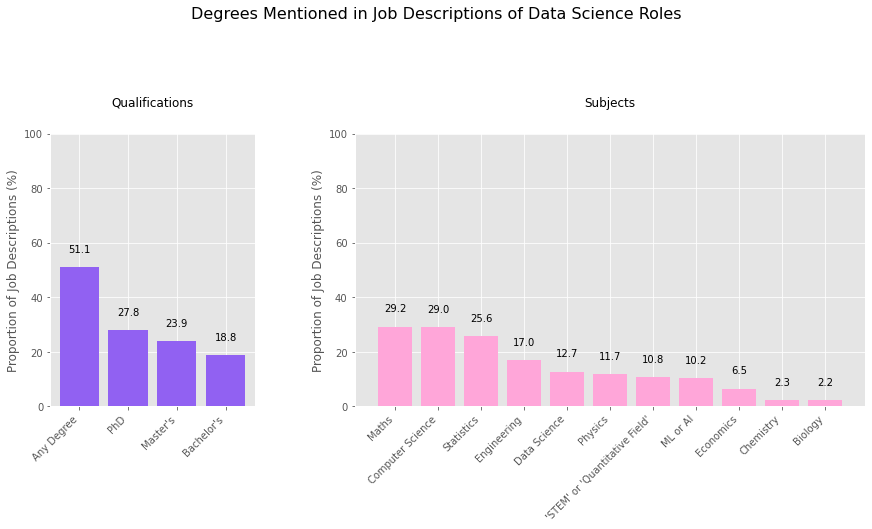

In [84]:
# plot % jobs mentioning various degree qualifications and subjects
plt.style.use('ggplot')

fig = plt.figure(constrained_layout=True, figsize=(12, 6))
spec = gridspec.GridSpec(ncols=15, nrows=1, figure=fig)
ax1 = fig.add_subplot(spec[0, :4])
ax2 = fig.add_subplot(spec[0, 5:])

# ax1: qualifications

# order the results dict so they can be plotted in descending order
dict_qualifications_results = dict(  # otherwise it will output a list
    sorted(
        dict_qualifications_results.items(), 
        key=lambda item: item[1],  # key = a function to decide the order by pct
        reverse=True  # True will sort descending
    )
)

# extract the results into lists to be used for plotting
degree_li = list(dict_qualifications_results.keys())
degree_pcts = list(dict_qualifications_results.values())
degree_x = np.arange(len(degree_li))

# plot and plot settings
ax1.grid(axis='x', zorder=0)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.bar(degree_li, degree_pcts, align='center', zorder=3, color=purple)
ax1.set_ylim(0, 100)
ax1.set_ylabel("Proportion of Job Descriptions (%)", fontsize=12)
ax1.set_xticks(degree_x)
ax1.set_xticklabels(degree_li, rotation=45, ha='right', va='top')

# annotate with %s
for x, y in zip(degree_x, degree_pcts):
    label = str(y)
    ax1.annotate(label, (x, y), textcoords='offset points',
                 xytext=(0, 15), ha='center')

ax1.set_title("Qualifications", fontsize=12, y=1.08, x=0.5)

# ax2: subjects

# order the results dict so they can be plotted in descending order
dict_degsubjects_results = dict(sorted(
    dict_degsubjects_results.items(), 
    key=lambda item: item[1], 
    reverse=True)
)

# extract the results into lists to be used for plotting
subjects_li = list(dict_degsubjects_results.keys())
subjects_pcts = list(dict_degsubjects_results.values())
subjects_x = np.arange(len(subjects_li))

# plot and plot settings
ax2.grid(axis='x', zorder=0)
ax2.bar(subjects_li, subjects_pcts, align='center', zorder=3, color=pink)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_ylim(0, 100)
ax2.set_ylabel("Proportion of Job Descriptions (%)", fontsize=12)
ax2.set_xticks(subjects_x)
ax2.set_xticklabels(subjects_li, rotation=45, ha='right', va='top')

# annotate with %s
for x, y in zip(subjects_x, subjects_pcts):
    label = str(y)
    ax2.annotate(label, (x, y), textcoords='offset points',
                 xytext=(0, 15), ha='center', wrap=True)

ax2.set_title("Subjects", fontsize=12, y=1.08, x=0.5)
fig.suptitle('Degrees Mentioned in Job Descriptions of Data Science Roles',
             fontsize=16, y=1.2, x=0.5)
plt.savefig("./images/pt4_figures/education.jpg", dpi=300, bbox_inches = 'tight')
plt.show()


More than half of jobs mention having a degree of some sort, with almost a third mentioning having a PhD, indicating that most employers believe a strong academic background is required for a data scinetist role. Maths, Computer Science, and Statistics are the bost often mentioned degree subjects. Almost 13% mention having a degree in Data Science, which have only been offered by universities, usually as a Master's, very recently. More than 10% of jobs menion having a degree in any STEM or "quantitative" field, but Chemistry and Biology are only specifically mentioned in ~2% jobs.

### Experience: which skills and tools do employers mention?


To be able to analyse which skills and experience employers of data scientists are most interested in, in Part 2, as I did for qualifications and degree subjects, I searched the job description text for mentions of various data science skills and tools. As for the degree qualifications/subjects, the results were recorded in a boolean column for each skill/tool, and the column headers and string labels for each skill/tool were pickled as dictonaries to be used for analysing/plotting, here. 

In [85]:
# calculate % jobs mentioning various skills/tools

# initialise a dictionary to store skills results
dict_skills_results = {}

# identify skills mentioned in >1% jobs
for key, val in dsjobs_dicts['dict_skills'].items():
    pct_allds = dsjobs[key].mean()*100
    label = val['label']
    if pct_allds >= 2:
        dict_skills_results[label] = pct_allds.round(1)

# initialise a dictionary to store tools results
dict_tools_results = {}

# identify skills mentioned in >1% jobs
for key, val in dsjobs_dicts['dict_tools'].items():
    pct_allds = dsjobs[key].mean()*100
    label = val['label']
    if pct_allds >= 2:
        dict_tools_results[label] = pct_allds.round(1)


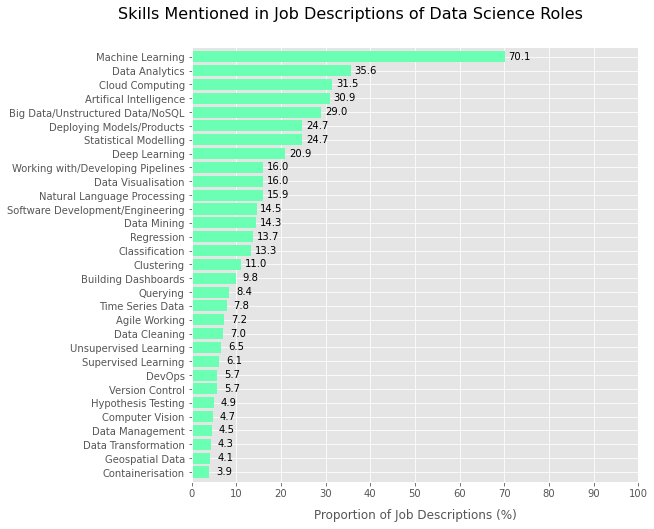

In [86]:
# plot % of jobs mentioning various skills
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(8,8))

plt.suptitle(
    "Skills Mentioned in Job Descriptions of Data Science Roles", fontsize=16, x=0.4, y=0.95)

# order the results so that they can be plotted in descending order
dict_skills_results = dict(
    sorted(dict_skills_results.items(), key=lambda item: item[1], reverse=False))

# extract the results into lists to be used for plotting
skills_li = list(dict_skills_results.keys())
skills_pcts_allds = list(dict_skills_results.values())
skills_x = np.arange(len(skills_li))

# plot and plot settings
ax.margins(0.01)
ax.barh(y=skills_li, width=skills_pcts_allds, color=green)
ax.set_xlim(0, 100)
ax.set_xticks(np.arange(0, 101, 10), minor=False)
ax.set_xlabel("Proportion of Job Descriptions (%)", fontsize=12, labelpad=10)
for x, y in zip(skills_x-0.175, skills_pcts_allds):
    label = str(y)
    ax.annotate(label, (y, x), textcoords='offset points',
        xytext=(15, 0), ha='center')
plt.savefig("./images/pt4_figures/skills.jpg", dpi=300, bbox_inches = 'tight')
plt.show()

The bar plot above shows that the data science skills most commonly mentioned in job descriptions are machine learning, data analytics, cloud computing, AI, working with big/unstructured data, deploying models/products, statistical modelling and deep learning. 

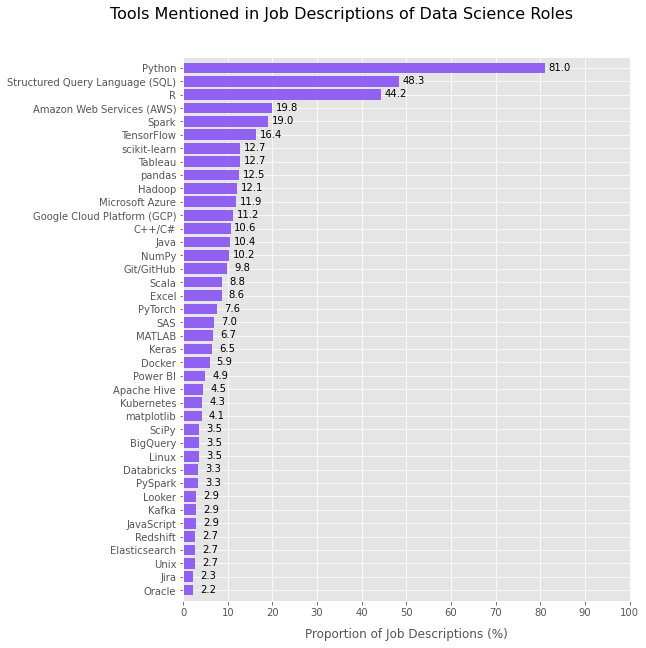

In [87]:
# plot % of jobs mentioning various tools
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(8, 10))

plt.suptitle(
    "Tools Mentioned in Job Descriptions of Data Science Roles", fontsize=16, x=0.4, y=0.95)

# order the results so that they can be plotted in descending order
dict_tools_results = dict(
    sorted(dict_tools_results.items(), key=lambda item: item[1], reverse=False))

# extract the results into lists to be used for plotting
tools_li = list(dict_tools_results.keys())
tools_pcts_allds = list(dict_tools_results.values())
tools_x = np.arange(len(tools_li))

# plot and plot settings
ax.margins(0.01)
ax.barh(y=tools_li, width=tools_pcts_allds, color=purple)
ax.set_xlim(0, 100)
ax.set_xticks(np.arange(0, 101, 10), minor=False)
ax.set_xlabel("Proportion of Job Descriptions (%)", fontsize=12, labelpad=10)
for x, y in zip(tools_x-0.175, tools_pcts_allds):
    label = str(y)
    ax.annotate(label, (y, x), textcoords='offset points',
        xytext=(15, 0), ha='center')
plt.savefig("./images/pt4_figures/tools.jpg", dpi=300, bbox_inches = 'tight')
plt.show()

The majority of data science job descriptions mention at least one of the most popular object-orientated programming languages used in data science: python (the most popular), SQL and R. The next 3 most popular tools are AWS, Spark and TensorFlow, which are used for performing machine learning and deep learning on large data sets. The next 10 most popular tools (mentioned in 10-13% jobs) are all used/required for machine learning, data analytics, cloud computing, big data anaylsis and version control.

#### Seniority: what's different about senior data scientist roles?

There are enough senior data scientist roles in the data set to be able to see how senior roles differ in terms of the skills and experiences emploters are looking for.

In [88]:
# how many of the data science roles are not specified as senior positions?
print("Non-senior roles:", end=' ')
print(f"{dsjobs[~dsjobs.seniority_senior].shape[0]}/{len(dsjobs)}", end=' ')
print(f"({round((dsjobs[~dsjobs.seniority_senior].shape[0]/len(dsjobs)*100),2)}%)")

# how many of the data science roles are senior?
print("Senior roles:", end=' ')
print(f"{dsjobs[dsjobs.seniority_senior].shape[0]}/{len(dsjobs)}", end=' ') 
print(f"({round((dsjobs[dsjobs.seniority_senior].shape[0]/len(dsjobs)*100),2)}%)")


Non-senior roles: 371/511 (72.6%)
Senior roles: 140/511 (27.4%)


In [89]:
# get the % of jobs mentioning various skills and tools in 
# senior vs. non-senior roles and fold difference

# initialise a dictionary to store results
dict_skills_results = {}
# iterate through the skills dict to calculate % in snr and non-snr roles
for key, val in dsjobs_dicts['dict_skills'].items():
    pct_snr = dsjobs[dsjobs["seniority_senior"]][key].mean()*100
    pct_nonsnr = dsjobs[~dsjobs["seniority_senior"]][key].mean()*100
    fold_diff = pct_snr/pct_nonsnr
    label = val['label']
    # only store results for skills and tools mentioned in at least 2% jobs
    if (pct_snr >= 2 and pct_nonsnr >= 2):
        dict_skills_results[label] = [
            pct_nonsnr.round(1), 
            pct_snr.round(1), 
            fold_diff.round(2)
        ]

# initialise a dictionary to store results
dict_tools_results = {}
# iterate through the tools dict to calculate % in snr and non-snr roles
for key, val in dsjobs_dicts['dict_tools'].items():
    pct_snr = dsjobs[dsjobs["seniority_senior"]][key].mean()*100
    pct_nonsnr = dsjobs[~dsjobs["seniority_senior"]][key].mean()*100
    fold_diff = pct_snr/pct_nonsnr
    label = val['label']
    # only store results for skills and tools mentioned in at least 2% jobs
    if (pct_snr >= 2 and pct_nonsnr >= 2):
        dict_tools_results[label] = [
            pct_nonsnr.round(1), 
            pct_snr.round(1), 
            fold_diff.round(2)
        ]


C:\Users\hinal\AppData\Local\Temp/ipykernel_24588/2071914169.py:26: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\hinal\AppData\Local\Temp/ipykernel_24588/2071914169.py:26: RuntimeWarning:

divide by zero encountered in double_scalars



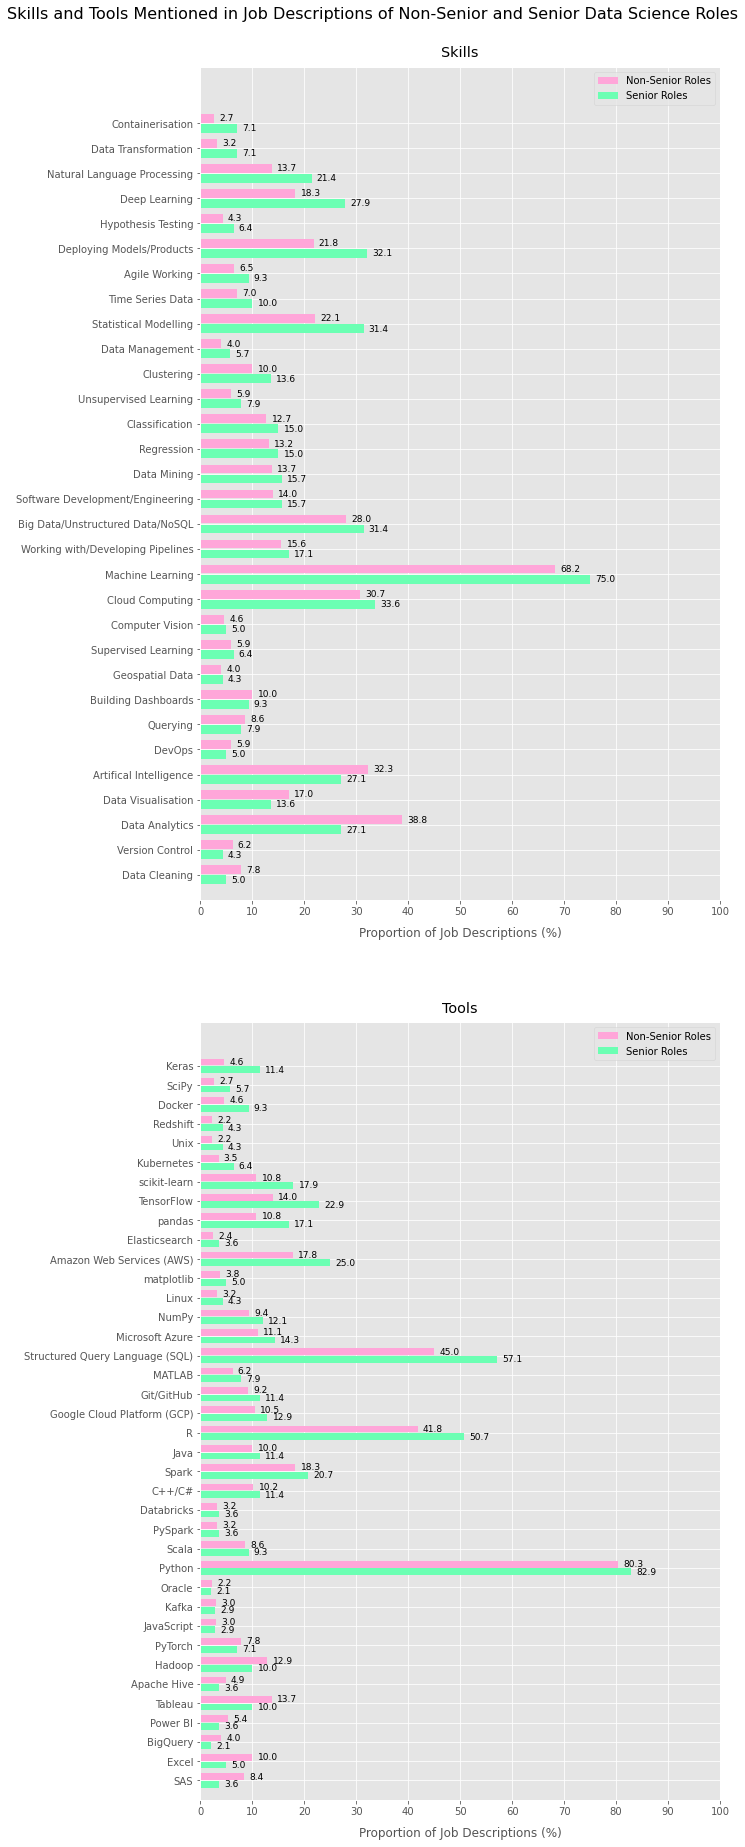

In [90]:
# set-up figure to plot % of jobs mentioning various skills and tools
plt.style.use('ggplot')
fig = plt.figure(constrained_layout=True, figsize=(10, 25))
spec = gridspec.GridSpec(ncols=1, nrows=30, figure=fig)
ax1 = fig.add_subplot(spec[:15, 0])
ax2 = fig.add_subplot(spec[16:, 0])
plt.suptitle(
    "Skills and Tools Mentioned in Job Descriptions of Non-Senior and Senior Data Science Roles", 
    fontsize=16, 
    y=1.02
)

# skills subplot
# order the % jobs mentioning skills by fold change (snr/non-snr)
dict_skills_results = dict(
    sorted(dict_skills_results.items(), key=lambda item: item[1][2], reverse=False))

skills_li = list(dict_skills_results.keys())
pcts = list(dict_skills_results.values())

skills_pcts_nonsnr = [x[0] for x in pcts]
skills_pcts_snr = [x[1] for x in pcts]
# skills_fold_diff = [x[2] for x in pcts]
skills_x = np.arange(len(skills_li))

# plot on ax1
ax1.barh(y=skills_x+0.2, width=skills_pcts_nonsnr,
           align='center', height=0.35, color=pink)
ax1.barh(y=skills_x-0.2, width=skills_pcts_snr,
           align='center', height=0.35, color=green)
ax1.legend(["Non-Senior Roles", "Senior Roles"], loc="upper right")
ax1.set_xlim(0, 100)
ax1.set_xticks(np.arange(0, 101, 10), minor=False)
ax1.set_xlabel("Proportion of Job Descriptions (%)", fontsize=12, labelpad=10)
ax1.set_ylim(-1, len(skills_x)+1.25)
ax1.set_yticks(np.arange(0, len(skills_x), 1))
ax1.set_yticklabels(skills_li)
ax1.set_title('Skills', pad=10)

# annotation
rects = ax1.patches
for rect in rects:
    x = rect.get_x()
    y = rect.get_y()
    width = rect.get_width()
    height = rect.get_height()
    ax1.annotate(text=width, xy=(x, y), xytext=(
        (x+width+1), (y+height/2)), ha='left', va='center', fontsize=9)

# tools subplot
# order the % jobs mentioning tools by fold change (snr/non-snr)
dict_tools_results = dict(
    sorted(dict_tools_results.items(), key=lambda item: item[1][2], reverse=False))

tools_li = list(dict_tools_results.keys())
pcts = list(dict_tools_results.values())

tools_pcts_nonsnr = [x[0] for x in pcts]
tools_pcts_snr = [x[1] for x in pcts]
# tools_fold_diff = [x[2] for x in pcts]
tools_x = np.arange(len(tools_li))

# plot on ax2
ax2.barh(y=tools_x+0.2, width=tools_pcts_nonsnr,
           align='center', height=0.35, color=pink)
ax2.barh(y=tools_x-0.2, width=tools_pcts_snr,
           align='center', height=0.35, color=green)
ax2.legend(["Non-Senior Roles", "Senior Roles"], loc="upper right")
ax2.set_xlim(0, 100)
ax2.set_xticks(np.arange(0, 101, 10), minor=False)
ax2.set_xlabel("Proportion of Job Descriptions (%)", fontsize=12, labelpad=10)
ax2.set_ylim(-1, len(tools_x)+1.25)
ax2.set_yticks(np.arange(0, len(tools_x), 1))
ax2.set_yticklabels(tools_li)
ax2.set_title('Tools', pad=10)

# annotation
rects = ax2.patches
for rect in rects:
    x = rect.get_x()
    y = rect.get_y()
    width = rect.get_width()
    height = rect.get_height()
    ax2.annotate(text=width, xy=(x, y), xytext=(
        (x+width+1), (y+height/2)), ha='left', va='center', fontsize=9)

plt.savefig("./images/pt4_figures/skillstoolsenority.jpg", dpi=300, bbox_inches = 'tight')
plt.show()


Plotting the proportion of job descriptions mentioning the various skills and tools that we have chosen, we can see that while some skills and tools are mentioned at a similar frequency in non-senior and senior roles, the differences suggest that:

- More senior role descriptions mention *specific* higher level skills, e.g. 
    - "Containerisation", 
    - "Data Transformation", 
    - "Natural Language Processing", 
    - "Deep Learning", 
    - "Hypothesis Testing",  
    - "Deploying Models/Products", and 
    - "Statistical Modelling"

- More non-senior roles mention more general/common skills or terminology, e.g. 
    - "Artifical Intelligence", 
    - "Data Visualisation", 
    - "Data Analytics", and 
    - "Data Cleaning"

- Senior role descriptions are also more detailed and specific with respect to tools; almost all tools are mentioned at similar or higher frequencies in senior role descriptions

- However, the tools that stand out as being a lot more commonly mentioned in senior role descriptions are related to the more advanced skills required in senior positions, e.g. 
    - Docker (a minimal virtual environments [containers] for containerisation), 
    - Kubernetes (used to orchestrate the deployment of multiple containers deployed across multiple servers using an API), 
    - RedShift (a cloud-based, big data warehouse product; can be used for real-time analytics using SQL),
    - SciPy (python library used for scientific and technical computing), 
    - sci-kit learn (python machine learning library), and 
    - TensorFlow (a software library for machine learning, including deep neural networks)

## Salary: how much do UK data scientist jobs pay?

In [91]:
# look at the mean salary midpoint (since salaries are almost always 
# given as a range; the midpoint is used as a proxy average)
round(np.mean(dsjobs['salary_mid'].dropna()))

47

The mean salary midpoint is £47K/year

In [92]:
#calculate the interquartile range of the salary estimate midpoints
q3, q1 = np.percentile(dsjobs['salary_mid'].dropna(), [75 ,25])
iqr = q3 - q1
print(q1, q3, iqr)

38.0 52.0 14.0


The quantiles and interquartile range of the salary estimate midpoint at 14K indicates that the average salary that most employers are offering fall within a narrow window between £38K and £52K per year.

To better appreciate the distrubution of salaries on offer, I'll plot the salary midpoints in both a swarm plot and a violin plot: 
- A swarm plot is a type of scatter plot used for representing categorical values without overlapping them. The lack of smoothing is ideal to avoid being misled by small sample sizes, but the distribution is harder to interpret without smoothing, it avoids the risk of being misled.

- A violin plot is similar to a box and whisker plot but instead of all of the plot components corresponding to actual datapoints (min, max, quantiles, and median), the violin plot is a kernel density estimation of the underlying distribution; this smoothing makes the distribution easier to interpret and the plot allows the distribution of different categories easier to compare, but if the data are split thinly then the violin plot can be misleading.

c:\Users\hinal\anaconda3\envs\eda-proj\lib\site-packages\seaborn\categorical.py:1296: UserWarning:

5.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



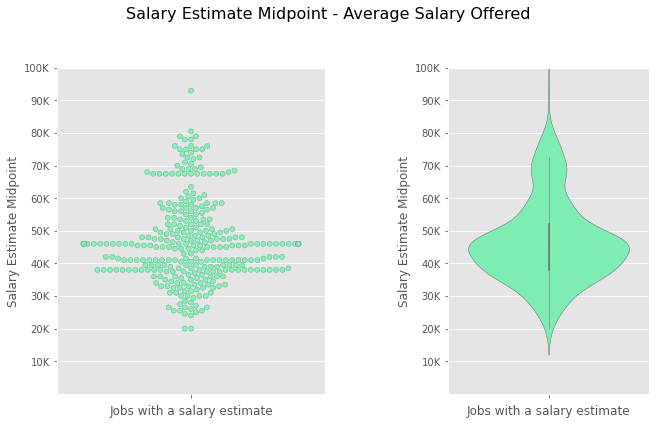

In [93]:
fig = plt.figure(constrained_layout=True, figsize=(9, 5))
spec = gridspec.GridSpec(ncols=8, nrows=1, figure=fig)
ax1 = fig.add_subplot(spec[0, :4])
ax2 = fig.add_subplot(spec[0, 5:])

# ax1
sns.swarmplot(
    y='salary_mid',
    data=dsjobs,
    size=5,
    ax=ax1,
    color=green,
    edgecolor="#999999",
    # alpha=.5, 
    linewidth=0.5
    )
ax1.set_yticks(
    ticks=[10,20,30,40,50,60,70,80,90,100], 
    labels=["10K","20K","30K","40K","50K","60K","70K","80K","90K","100K"],
    )
ax1.set_ylim(0,100)
ax1.set_ylabel("Salary Estimate Midpoint")
ax1.set_xlabel("Jobs with a salary estimate")

#ax2
sns.violinplot(
    y='salary_mid',
    data=dsjobs,
    # size=5,
    ax=ax2,
    color=green,
    linewidth=0.5
    )
ax2.set_yticks(
    ticks=[10,20,30,40,50,60,70,80,90,100], 
    labels=["10K","20K","30K","40K","50K","60K","70K","80K","90K","100K"],
    )
ax2.set_ylim(0,100)
ax2.set_ylabel("Salary Estimate Midpoint")
ax2.set_xlabel("Jobs with a salary estimate")



fig.suptitle("Salary Estimate Midpoint - Average Salary Offered", y=1.15, fontsize=16)
plt.savefig("./images/pt4_figures/salaries.jpg", dpi=300, bbox_inches = 'tight')
plt.show()

The distribution of the salary estimate midpoints doesn't look like a guassian (normal) distribution, but I'll do a normalilty test to check it:

In [94]:
from scipy.stats import shapiro
# normality test
data = dsjobs['salary_mid'].dropna().to_numpy()
print(type(data))
stat, p = shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')


<class 'numpy.ndarray'>
Statistics=0.947, p=0.000
Sample does not look Gaussian (reject H0)


The shapiro wilk test result confirms that the salary range midpoints are not normally distributed. Therefore these data cannot be used to make any reliable salary predictions based on other job role criteria. 

The swarm plot indicates a distribution with maybe 3 or 4 peaks:

1. ~ 38K - 42K
2. ~ 46K
3. ~ 67K

These might represent different market rates for data scientist roles, most likely dependant on:

- Senority: Senior vs non-senior role
- Location: London vs. non-London position

I'll split the salary midpoints into groups based on these variables (seniority and location) and compare them using violin plots. A violin plot plays a similar role to a box and whisker plot, by showing the distribution of your data but unlike a box plot, in which all of the plot components drawn are actual datapoints, the violin plot is created with a smoothing of the underlying distribution using kernel density estimation, which makes comparing distributions easier.

In [95]:
# create boolean masks/series indicating jobs  in dsjobs that are:

# in london
in_london = pd.Series(dsjobs['api_citytownvilham']=="London", dtype="bool")

# senior roles
snr = pd.Series(dsjobs['seniority_senior'], dtype="bool")

# mention ML/AI
ml_exp = pd.Series(dsjobs['title_mlai'], dtype="bool")

# use the series and scraped salary estimates to create a DataFrame
loc_sal_df = pd.DataFrame({
    "salary_mid" : dsjobs['salary_mid'],
    "in_london" : in_london,
    "senior" : snr,
    "ml_exp" : ml_exp,
})

# drop jobs that didn't have a salary estimate
loc_sal_df.dropna(inplace=True)

In [96]:
# sample the dataframe for jobs that are:

# non-senior roles in london
nonsnr_in_lnd = loc_sal_df[(loc_sal_df["senior"]==False) & (loc_sal_df["in_london"]==True)]

# non-senior roles outside london
nonsnr_not_lnd = loc_sal_df[(loc_sal_df["senior"]==False) & (loc_sal_df["in_london"]==False)]

# senior roles in london
snr_in_lnd = loc_sal_df[(loc_sal_df["senior"]==True) & (loc_sal_df["in_london"]==True)]

# senior roles outside london
snr_not_lnd = loc_sal_df[(loc_sal_df["senior"]==True) & (loc_sal_df["in_london"]==False)]


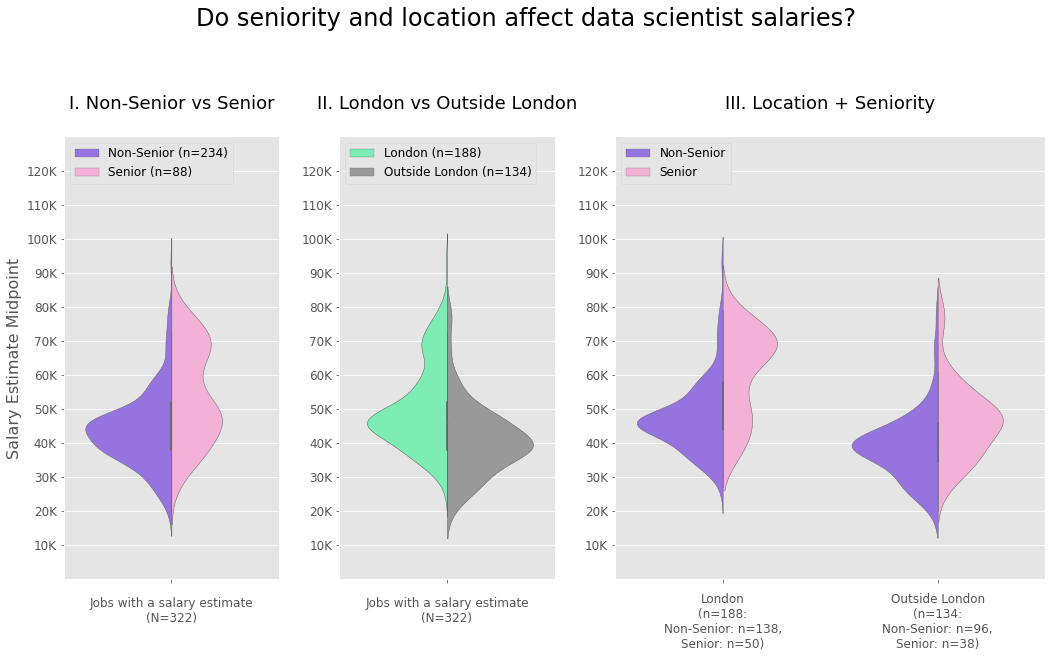

In [97]:
# violin plots comparing salaries of non-senior and senior roles in/outside london

# landscape figure with 3 axes
fig = plt.figure(constrained_layout=True, figsize=(14.5, 7.81))
spec = gridspec.GridSpec(ncols=12, nrows=1, figure=fig)
ax1 = fig.add_subplot(spec[0, :3])
ax2 = fig.add_subplot(spec[0, 3:6])
ax3 = fig.add_subplot(spec[0, 6:])

# set yticks for all plots
yticks=[10,20,30,40,50,60,70,80,90,100,110,120]
ylabels=["10K","20K","30K","40K","50K","60K","70K","80K","90K","100K",
    "110K","120K"]

# ax1: non-senior vs. senior
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
sns.violinplot(
    y=loc_sal_df['salary_mid'],
    x=['']*len(loc_sal_df),
    hue=loc_sal_df["senior"],
    hue_order=[False,True],
    split=True,
    ax=ax1,
    palette=[purple, pink],
    linewidth=0.5)
ax1.set_xlabel(f"Jobs with a salary estimate\n(N={len(loc_sal_df)})")
ax1.tick_params(axis='x', which='major', pad=10)
ax1.set_ylabel("Salary Estimate Midpoint", fontsize=16)
ax1.set_yticks(ticks=yticks, labels=ylabels, fontsize=12)
ax1.set_ylim(0,130)
ax1.set_title("I. Non-Senior vs Senior", fontsize=18, y=1.05, x=0.5)
ax1.legend(
    handles=ax1.legend_.legendHandles, 
    labels=[
        f'Non-Senior (n={len(loc_sal_df) - sum(loc_sal_df["senior"])})', 
        f'Senior (n={sum(loc_sal_df["senior"])})'],
    loc='upper left',
    fontsize=12
    )

# ax2: in london vs. outside london
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
sns.violinplot(
    y=loc_sal_df['salary_mid'],
    x=['']*len(loc_sal_df),
    hue=loc_sal_df["in_london"],
    hue_order=[True,False],
    split=True,
    ax=ax2,
    palette=[green, grey],
    linewidth=0.5)
ax2.set_xlabel(f"Jobs with a salary estimate\n(N={len(loc_sal_df)})")
ax2.tick_params(axis='x', which='major', pad=10)
ax2.set_ylabel(" ")
ax2.set_yticks(ticks=yticks, labels=ylabels, fontsize=12)
ax2.set_ylim(0,130)
ax2.set_title("II. London vs Outside London", fontsize=18, y=1.05, x=0.5)
ax2.legend(
    handles=ax2.legend_.legendHandles, 
    labels=[
        f'London (n={sum(loc_sal_df["in_london"])})',
        f'Outside London (n={len(loc_sal_df) - sum(loc_sal_df["in_london"])})'],
    loc='upper left',
    fontsize=12
    )

# ax3: pairwise comparison of senior/non-senior roles vs london/non-london jobs
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
sns.violinplot(
    y=loc_sal_df['salary_mid'],
    x=loc_sal_df['in_london'],
    order=[True,False],
    hue=loc_sal_df["senior"],
    hue_order=[False,True],
    split=True,
    ax=ax3,
    palette=[purple,pink],
    linewidth=0.5)
ax3.set_xlabel(None)
ax3.set_xticklabels([
    f'London\n(n={sum(loc_sal_df.in_london)}:\n'
    f'Non-Senior: n={len(nonsnr_in_lnd)},\nSenior: n={len(snr_in_lnd)})', 
    f'Outside London\n(n={len(loc_sal_df) - sum(loc_sal_df.in_london)}:\n'
    f'Non-Senior: n={len(nonsnr_not_lnd)},\nSenior: n={len(snr_not_lnd)})'],
    fontsize=12)
ax3.tick_params(axis='x', which='major', pad=10)
ax3.set_ylabel(" ")
ax3.set_yticks(ticks=yticks, labels=ylabels, fontsize=12)
ax3.set_ylim(0,130)
ax3.set_title("III. Location + Seniority", fontsize=18, y=1.05, x=0.5)
ax3.legend(
    handles=ax3.legend_.legendHandles, 
    labels=['Non-Senior', 'Senior'], 
    loc='upper left',
    fontsize=12
    )

fig.suptitle(
    "Do seniority and location affect data scientist salaries?", 
    fontsize=24, 
    y=1.15)

plt.savefig("./images/pt4_figures/salarieslocationsenority.jpg", dpi=300, bbox_inches = 'tight')
plt.show()

**I.** The plot comparing non-senior and senior roles shows that non-senior roles have a gaussian-like distribution of salary range midpoints with an average of around £45K/year, while the senior roles salary range midpoint distribution is bimodal: one peak at around £45K, and another around £70K.

**II.** When splitting the salary range midpoints by roles in/outside London, the average non-London salary drops to around £40K, while the distrbution of London salaries has two peaks: the main one at £45K, and a smaller one around 70K, which could be explained by most senior roles being inside London

**III.** Splitting London and non-London jobs by senior vs. non-senior roles shows that the salary range mid-point  on non-senior roles isn't very different for jobs in and outside on London (£45K vs £40K), while the salary range midpoint has a broad distrubution averaging just over £45K outside London, while in London, more senior roles pay around £70K but a large proportion also pay around £45K.

**These violin plots tell us that for non-senior positions, there is no benefit to being based in London when it comes to salary, but for senior positions in London tend to pay more than those outside of London.**